# 1. 환경 설정 및 데이터셋 경로, 클래스 ID 정의

In [16]:
import os
import json
import shutil
from glob import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Matplotlib 한글 폰트 설정
try:
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지
    print("한글 폰트 설정 완료 (NanumGothic)")
except Exception as e:
    print(f"경고: 한글 폰트 설정 중 오류 발생 ({e}). NanumGothic 폰트가 설치되어 있는지 확인해주세요.")

print("환경 설정 및 라이브러리 임포트 완료")

DATA_ROOT = '/home/user/codeit_team8_project1/data/raw'

# 훈련 이미지 및 어노테이션 폴더 경로
TRAIN_IMG_DIR = os.path.join(DATA_ROOT, 'train_images_TL_3')
TRAIN_ANNO_DIR = os.path.join(DATA_ROOT, 'train_annotations_TL_3')

print(f"데이터셋 루트: {DATA_ROOT}")
print(f"훈련 이미지 디렉토리: {TRAIN_IMG_DIR}")
print(f"훈련 어노테이션 디렉토리: {TRAIN_ANNO_DIR}")

# 디렉토리 존재 여부 확인 및 입력 유도
if not os.path.exists(TRAIN_IMG_DIR) or not os.path.exists(TRAIN_ANNO_DIR):
    print("\n경고: 현재 설정된 데이터셋 경로 중 하나 이상을 찾을 수 없습니다.")
    suggested_root_raw = input("올바른 'data/raw'의 절대 경로를 입력하세요 (예: /home/user/my_project/data/raw): ")
    
    if os.path.exists(os.path.join(suggested_root_raw, 'train_images_TL_3')) and \
       os.path.exists(os.path.join(suggested_root_raw, 'train_annotations_TL_3')):
        
        DATA_ROOT = suggested_root_raw
        TRAIN_IMG_DIR = os.path.join(DATA_ROOT, 'train_images_TL_3')
        TRAIN_ANNO_DIR = os.path.join(DATA_ROOT, 'train_annotations_TL_3')
        print(f"\n경로가 '{DATA_ROOT}'(으)로 업데이트 되었습니다. 계속 진행합니다.")
        print(f"새 훈련 이미지 디렉토리: {TRAIN_IMG_DIR}")
        print(f"새 훈련 어노테이션 디렉토리: {TRAIN_ANNO_DIR}")
    else:
        print("입력된 경로도 유효하지 않습니다. 프로그램을 종료합니다. 경로를 다시 확인해주세요.")
        exit()

# 56개 클래스 ID
# JSON의 'dl_idx' 필드와 매칭되는 문자열 형태의 ID 집합
target_56_class_ids = {'1899', '2482', '3350', '3482', '3543', '3742', '3831', '4542', '12080', '12246', '12777', '13394', '13899', '16231', '16261', '16547', '16550', '16687', '18146', '18356', '19231', '19551', '19606', '19860', '20013', '20237', '20876', '21324', '21770', '22073', '22346', '22361', '24849', '25366', '25437', '25468', '27732', '27776', '27925', '27992', '28762', '29344', '29450', '29666', '30307', '31862', '31884', '32309', '33008', '33207', '33879', '34596', '35205', '36636', '38161', '41767'}

print(f"\n확인된 target_56_class_ids의 개수: {len(target_56_class_ids)}")

한글 폰트 설정 완료 (NanumGothic)
환경 설정 및 라이브러리 임포트 완료
데이터셋 루트: /home/user/codeit_team8_project1/data/raw
훈련 이미지 디렉토리: /home/user/codeit_team8_project1/data/raw/train_images_TL_3
훈련 어노테이션 디렉토리: /home/user/codeit_team8_project1/data/raw/train_annotations_TL_3

확인된 target_56_class_ids의 개수: 56


# 2. JSON 파싱 및 데이터 추출, 필터링

In [22]:
# --- 헬퍼 함수 정의 ---
def find_json_files_recursively(root_dir):
    json_files = []
    if not os.path.exists(root_dir):
        print(f"경고: JSON 파일을 탐색할 '{root_dir}' 경로가 존재하지 않습니다.")
        return []
    # JSON 파일 경로 패턴에 맞춰 glob 사용 (K-*_json/K-*/.json)
    search_pattern = os.path.join(root_dir, 'K-*_json', 'K-*', '*.json')
    json_files = glob(search_pattern, recursive=True)
    return json_files


print("\n--- 어노테이션 파일 탐색 중 ---", flush=True)
annotation_json_paths = find_json_files_recursively(TRAIN_ANNO_DIR)
print(f"총 훈련 어노테이션 파일 개수: {len(annotation_json_paths)}", flush=True)

if not annotation_json_paths:
    print("어노테이션 JSON 파일을 찾을 수 없습니다. 프로그램을 종료합니다. 경로를 다시 확인해주세요.", flush=True)
    exit()

print("\n--- JSON 파일 파싱 및 데이터 추출 중 (개별 JSON 파일 디버깅 시작) ---", flush=True)
all_image_data = [] # 각 이미지(JSON 파일)의 주요 메타데이터를 저장
all_bbox_data = []  # 각 바운딩 박스 어노테이션 정보를 저장

image_id_counter = 0 # 각 이미지에 고유 ID를 부여 (원본 JSON에 image_id가 1로 고정될 수 있어 별도로 관리)

# 처리된 JSON 파일 수를 카운트하여 디버그 메시지 조절 (너무 많으면 출력 과다)
processed_json_count = 0
debug_message_limit = 100 # 처음 100개 파일까지만 상세 디버그 메시지 출력
skipped_json_count = {'images_section_missing': 0, 'file_name_missing': 0, 'dl_idx_missing': 0, 'json_decode_error': 0, 'other_error': 0}

for json_path in annotation_json_paths:
    processed_json_count += 1
    
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            anno_data = json.load(f)
        
        # 'images' 섹션에서 이미지 파일명 및 주요 메타데이터 추출
        if 'images' not in anno_data or not anno_data['images']:
            if processed_json_count <= debug_message_limit:
                print(f"디버그: '{os.path.basename(json_path)}' - 'images' 섹션이 없거나 비어 있습니다. 건너뜀.", flush=True)
            skipped_json_count['images_section_missing'] += 1
            continue
        
        img_info = anno_data['images'][0] # 첫 번째 이미지 정보만 사용
        
        file_name = img_info.get('file_name')
        if not file_name:
            if processed_json_count <= debug_message_limit:
                print(f"디버그: '{os.path.basename(json_path)}' - 'file_name' 필드를 찾을 수 없습니다. 건너뜀.", flush=True)
            skipped_json_count['file_name_missing'] += 1
            continue
        
        current_dl_idx = img_info.get('dl_idx')
        if not current_dl_idx:
            if processed_json_count <= debug_message_limit:
                print(f"디버그: '{os.path.basename(json_path)}' - 'dl_idx' 필드를 찾을 수 없습니다. 건너뜀.", flush=True)
            skipped_json_count['dl_idx_missing'] += 1
            continue

        image_id_counter += 1
        
        # 이미지 메타데이터 저장
        image_entry = {
            'image_id': image_id_counter,
            'file_name': file_name,
            'width': img_info.get('width'),
            'height': img_info.get('height'),
            'dl_idx': current_dl_idx, 
            'drug_N': img_info.get('drug_N'), # 약품 고유 ID (K-XXXX)
            'dl_name': img_info.get('dl_name'),
            'dl_company': img_info.get('dl_company'),
            'drug_shape': img_info.get('drug_shape'),
            'color_class1': img_info.get('color_class1'),
            'print_front': img_info.get('print_front'),
            'print_back': img_info.get('print_back'),
            'json_path': json_path # 어떤 JSON에서 왔는지 기록
        }
        all_image_data.append(image_entry)

        # 'annotations' 섹션에서 바운딩 박스 정보 추출
        if 'annotations' in anno_data and anno_data['annotations']:
            for anno in anno_data['annotations']:
                bbox = anno.get('bbox') # [xmin, ymin, width, height]
                area = anno.get('area')

                if bbox and len(bbox) == 4:
                    all_bbox_data.append({
                        'image_id': image_id_counter, # 이미지 메타데이터와 연결하기 위한 ID
                        'dl_idx': current_dl_idx, # 이 바운딩 박스의 클래스 ID (dl_idx)
                        'bbox': bbox,
                        'xmin': bbox[0],
                        'ymin': bbox[1],
                        'bbox_width': bbox[2],
                        'bbox_height': bbox[3],
                        'area': area,
                        'file_name': file_name # 이 어노테이션이 속한 이미지 파일명
                    })
    except json.JSONDecodeError:
        if processed_json_count <= debug_message_limit:
            print(f"경고: '{os.path.basename(json_path)}' 파일이 유효한 JSON 형식이 아닙니다. 건너뜀.", flush=True)
        skipped_json_count['json_decode_error'] += 1
    except Exception as e:
        if processed_json_count <= debug_message_limit:
            print(f"경고: '{os.path.basename(json_path)}' 처리 중 알 수 없는 오류 발생: {e}. 건너뜀.", flush=True)
        skipped_json_count['other_error'] += 1

print("\n--- JSON 파일 파싱 및 데이터 추출 요약 ---", flush=True)
print(f"총 JSON 파일 개수: {processed_json_count}", flush=True)
print(f"images 섹션 누락/비어있음: {skipped_json_count['images_section_missing']}개", flush=True)
print(f"file_name 필드 누락: {skipped_json_count['file_name_missing']}개", flush=True)
print(f"dl_idx 필드 누락: {skipped_json_count['dl_idx_missing']}개", flush=True)
print(f"JSON Decode 오류: {skipped_json_count['json_decode_error']}개", flush=True)
print(f"기타 오류: {skipped_json_count['other_error']}개", flush=True)
print(f"성공적으로 파싱된 이미지 메타데이터 개수: {len(all_image_data)}개", flush=True)

print("\n--- 추출된 데이터로 DataFrame 생성 중 ---", flush=True)
images_df = pd.DataFrame(all_image_data)
annotations_df = pd.DataFrame(all_bbox_data)

print(f"생성된 images_df 크기: {len(images_df)}개의 이미지 메타데이터", flush=True)
print(f"생성된 annotations_df 크기: {len(annotations_df)}개의 어노테이션", flush=True)

if not images_df.empty:
    print(f"\n총 고유 `dl_idx` 개수 (파싱된 JSON): {images_df['dl_idx'].nunique()}", flush=True)
    print(f"\n`target_56_class_ids`에 정의된 클래스 개수: {len(target_56_class_ids)}", flush=True)
    print("\n--- `images_df`의 `dl_idx`와 `target_56_class_ids`의 교집합 ---", flush=True)
    common_dl_idx = set(images_df['dl_idx'].unique()).intersection(target_56_class_ids)
    print(f"교집합 개수: {len(common_dl_idx)}개", flush=True)
    if len(common_dl_idx) > 0:
        print(f"일치하는 `dl_idx` 예시: {list(common_dl_idx)[:5]}", flush=True)
    else:
        print("`images_df`의 `dl_idx`와 `target_56_class_ids` 사이에 일치하는 항목이 없습니다.", flush=True)
else:
    print("`images_df`가 비어있어 `dl_idx` 정보를 확인할 수 없습니다. JSON 파싱 과정에 문제가 있을 수 있습니다.", flush=True)

print(f"\n--- 56개 클래스 필터링 중 ---", flush=True)
# 이미지 메타데이터에서 56개 클래스 필터링
images_df_56_classes = images_df[images_df['dl_idx'].isin(target_56_class_ids)].copy()

# 어노테이션에서 56개 클래스 필터링 (image_id를 통해 images_df와 연결)
annotations_df_56_classes = annotations_df[
    annotations_df['image_id'].isin(images_df_56_classes['image_id'])
].copy()

print(f"필터링된 images_df (56개 클래스): {len(images_df_56_classes)}개의 이미지", flush=True)
print(f"필터링된 annotations_df (56개 클래스): {len(annotations_df_56_classes)}개의 어노테이션", flush=True)

if images_df_56_classes.empty:
    print("\n필터링된 56개 클래스 이미지가 없습니다. `target_56_class_ids` 목록과 JSON의 `dl_idx` 값이 일치하지 않을 가능성이 매우 높습니다. 위의 디버깅 정보를 확인하세요.", flush=True)


--- 어노테이션 파일 탐색 중 ---


총 훈련 어노테이션 파일 개수: 5732

--- JSON 파일 파싱 및 데이터 추출 중 (개별 JSON 파일 디버깅 시작) ---

--- JSON 파일 파싱 및 데이터 추출 요약 ---
총 JSON 파일 개수: 5732
images 섹션 누락/비어있음: 0개
file_name 필드 누락: 0개
dl_idx 필드 누락: 0개
JSON Decode 오류: 0개
기타 오류: 0개
성공적으로 파싱된 이미지 메타데이터 개수: 5732개

--- 추출된 데이터로 DataFrame 생성 중 ---
생성된 images_df 크기: 5732개의 이미지 메타데이터
생성된 annotations_df 크기: 5712개의 어노테이션

총 고유 `dl_idx` 개수 (파싱된 JSON): 65

`target_56_class_ids`에 정의된 클래스 개수: 56

--- `images_df`의 `dl_idx`와 `target_56_class_ids`의 교집합 ---
교집합 개수: 37개
일치하는 `dl_idx` 예시: ['3543', '16261', '38161', '25468', '22073']

--- 56개 클래스 필터링 중 ---
필터링된 images_df (56개 클래스): 3731개의 이미지
필터링된 annotations_df (56개 클래스): 3718개의 어노테이션


# 3. 56개 클래스 이미지 및 어노테이션 복사, EDA


--- 56개 클래스 이미지 및 어노테이션 파일 '/home/user/codeit_team8_project1/data/raw/selected_TL_3_data'으로 복사 중 ---
경고: 원본 이미지 '/home/user/codeit_team8_project1/data/raw/train_images_TL_3/K-003544-012247-016548-029451/K-003544-012247-016548-029451_0_2_0_2_70_000_200.png'를 찾을 수 없습니다. (dl_idx: 16547)
경고: 원본 이미지 '/home/user/codeit_team8_project1/data/raw/train_images_TL_3/K-003544-012247-016548-029451/K-003544-012247-016548-029451_0_2_0_2_90_000_200.png'를 찾을 수 없습니다. (dl_idx: 16547)
경고: 원본 이미지 '/home/user/codeit_team8_project1/data/raw/train_images_TL_3/K-003544-012247-016548-029451/K-003544-012247-016548-029451_0_2_0_2_75_000_200.png'를 찾을 수 없습니다. (dl_idx: 16547)
경고: 원본 이미지 '/home/user/codeit_team8_project1/data/raw/train_images_TL_3/K-003544-012247-016548-029451/K-003544-012247-016548-029451_0_2_0_2_70_000_200.png'를 찾을 수 없습니다. (dl_idx: 12246)
경고: 원본 이미지 '/home/user/codeit_team8_project1/data/raw/train_images_TL_3/K-003544-012247-016548-029451/K-003544-012247-016548-029451_0_2_0_2_90_000_200.png'를 찾을 수 

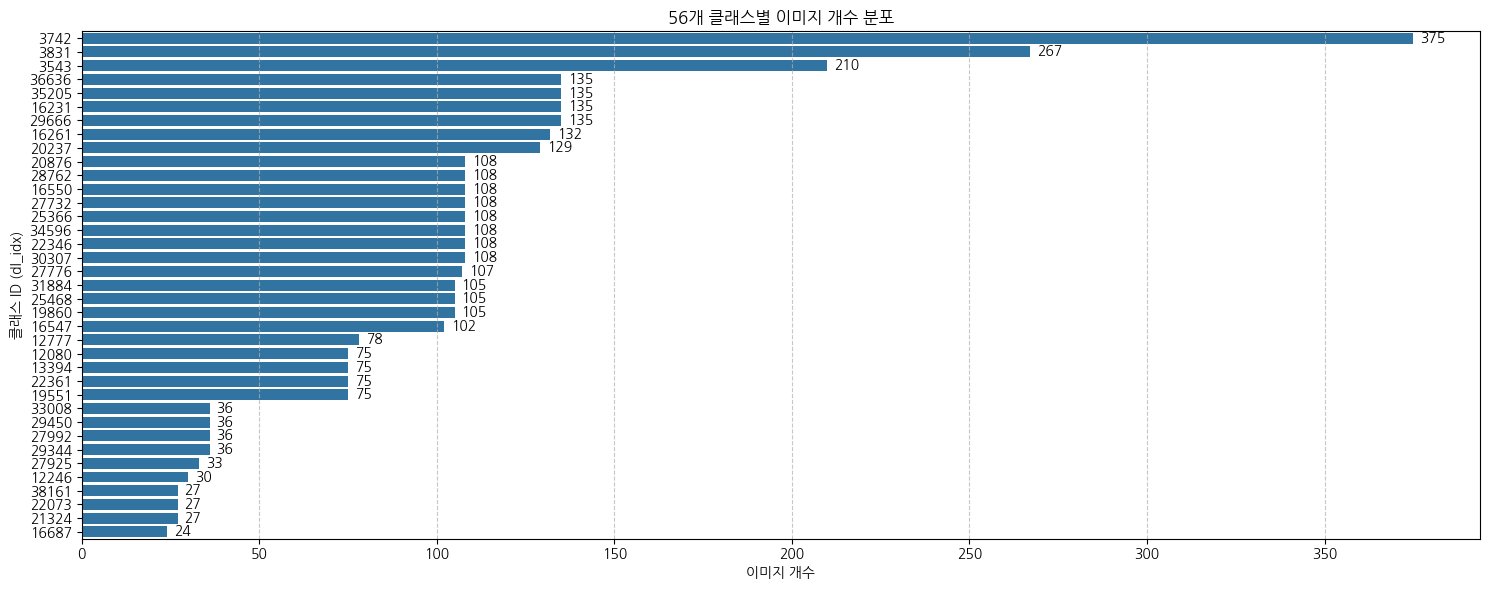

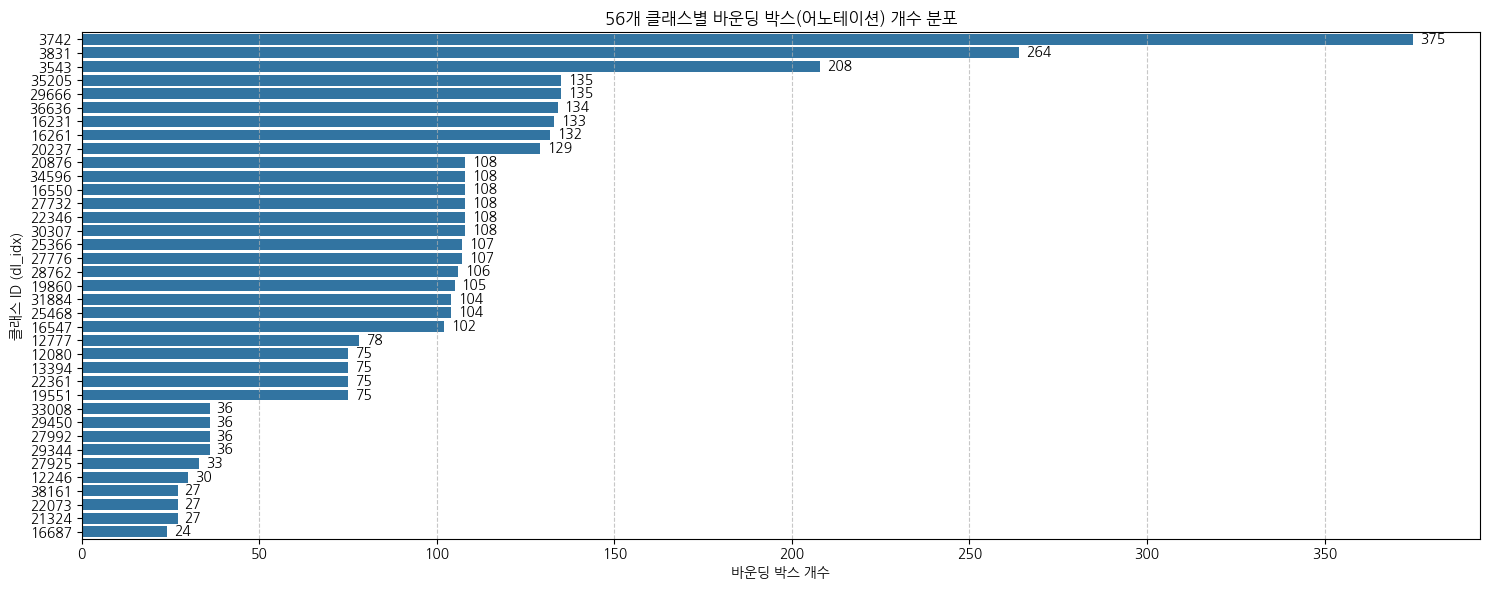


--- 2.4. 이미지 크기 분포 ---


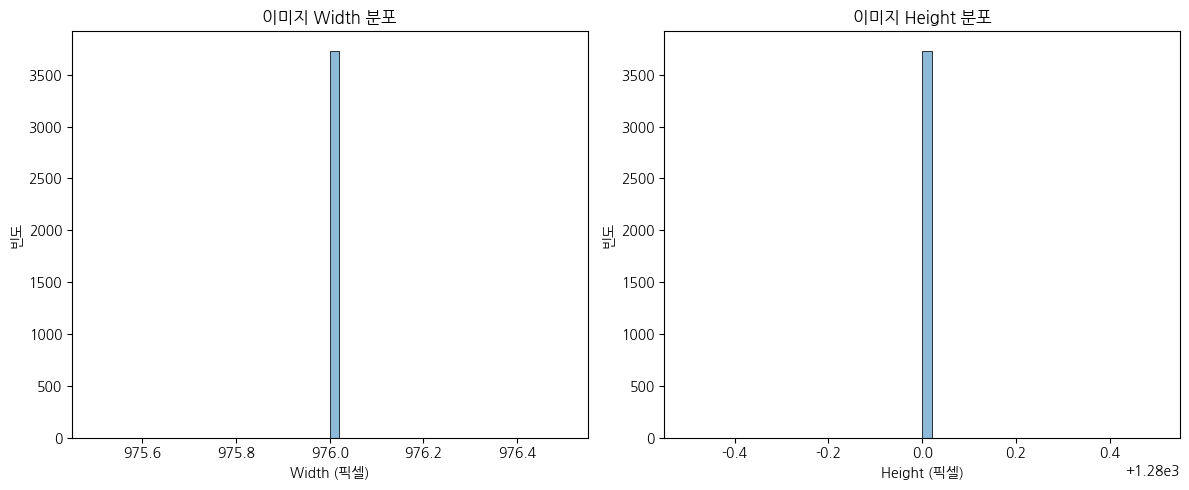

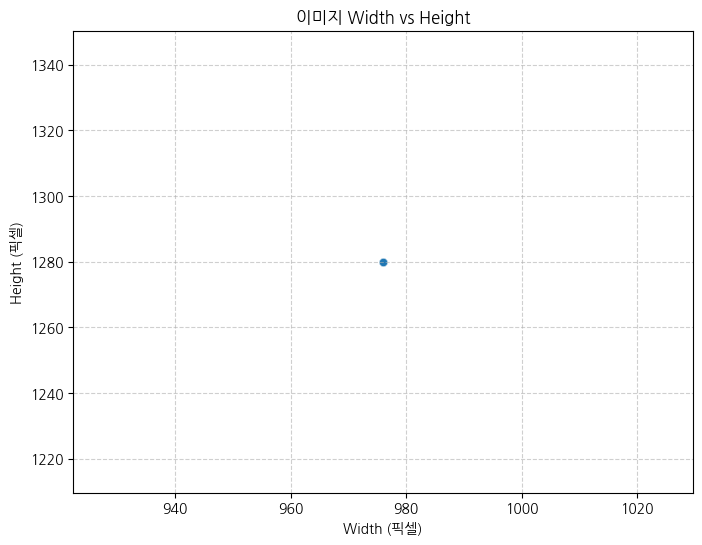


--- 2.5. 바운딩 박스 크기 분포 ---


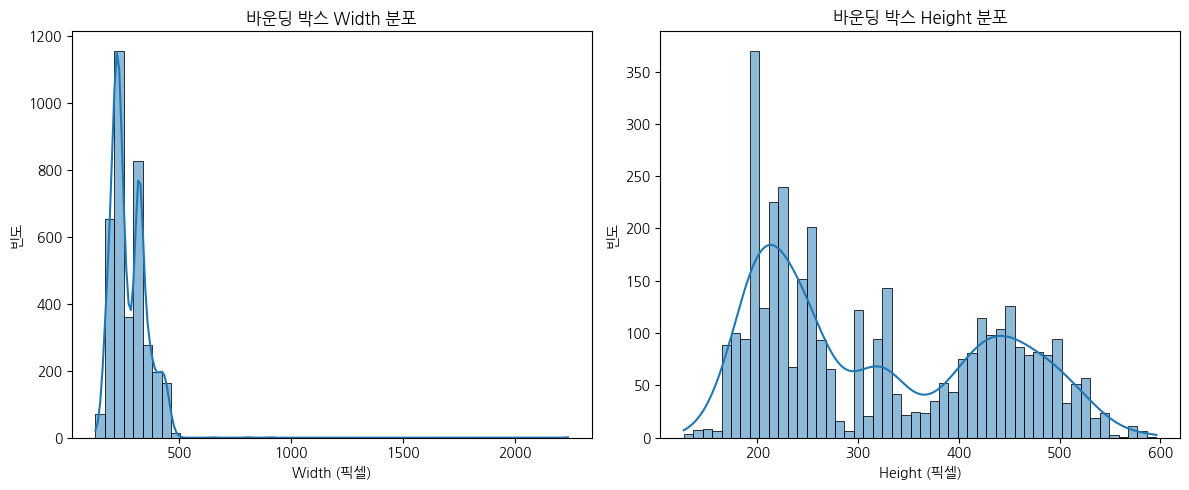

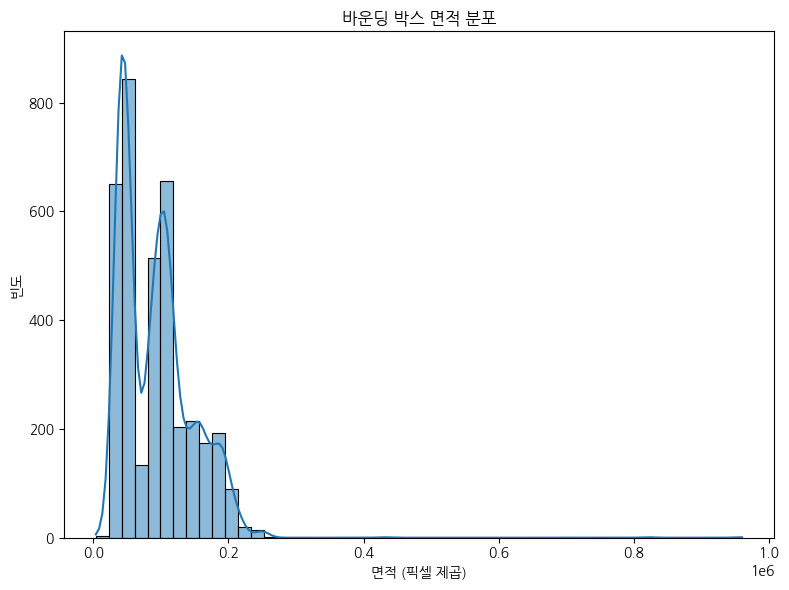

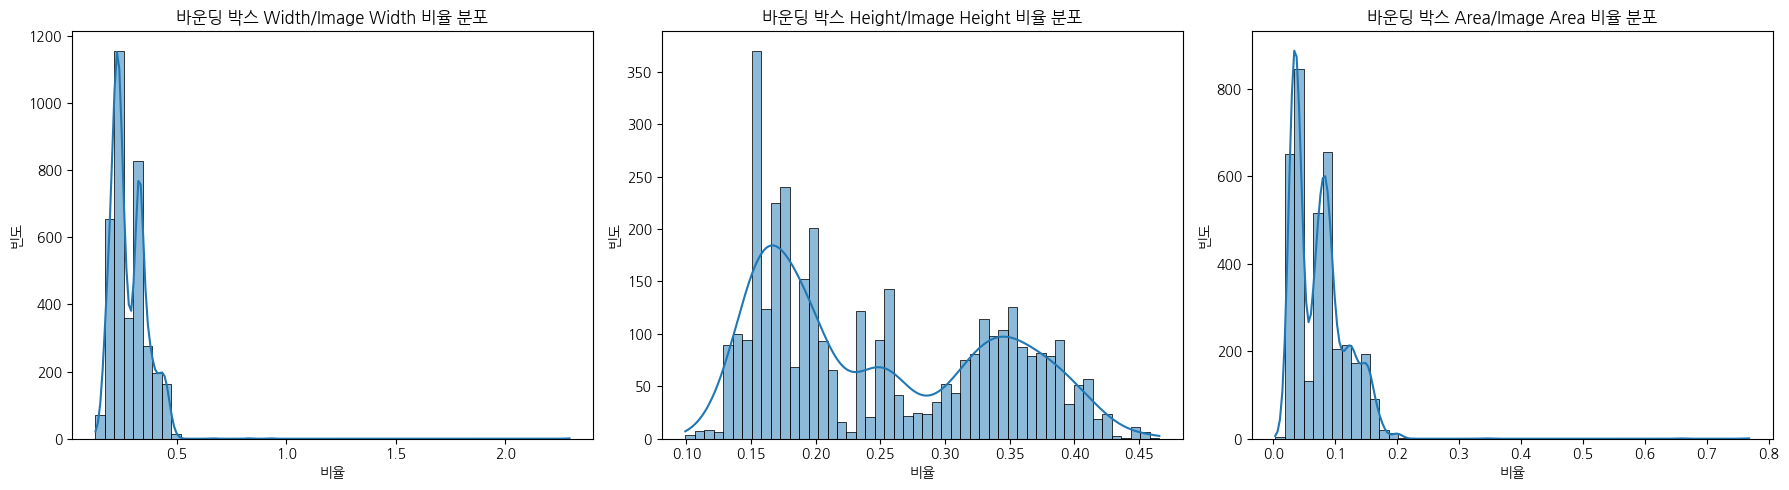


--- 2.6. 알약 속성 분포 (Images DataFrame) ---


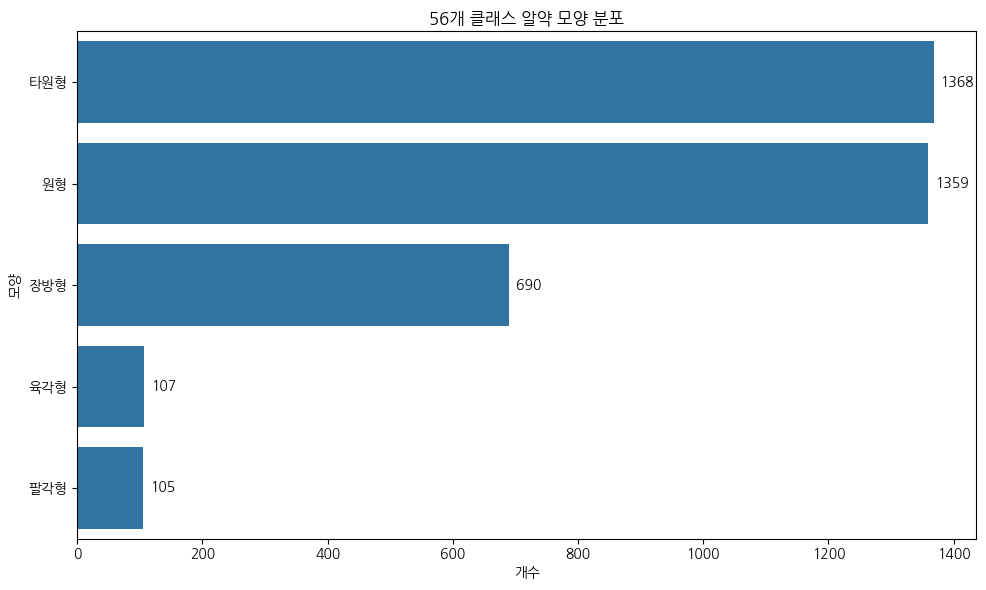

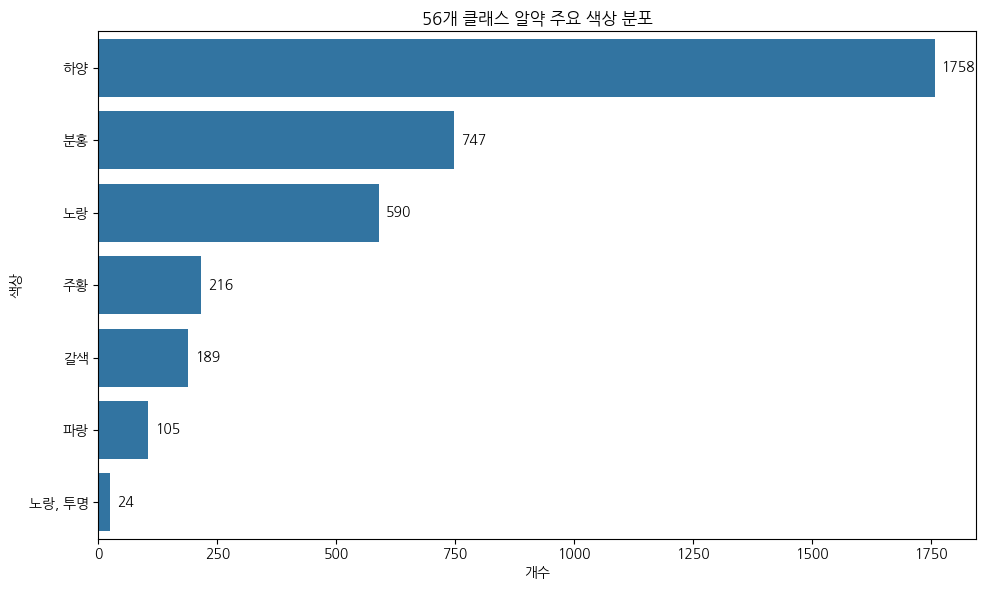


--- 앞면 각인 (print_front) 상위 20개 (56개 클래스) ---
print_front
마크            570
ALT           375
NR800         267
OG33          210
R5            135
337           135
ATV           135
마크203         135
ZD452220      132
75            129
마크 A1         108
NVR           108
DGTH          108
515           108
112           108
B분할선R         107
81            105
YH            102
Y분할선H          78
SUSPEN  ER     75
Name: count, dtype: int64

--- 뒷면 각인 (print_back) 상위 20개 (56개 클래스) ---
print_back
                   1668
분할선                 573
20                  162
1171                129
D5                  108
ECE                 108
800                 108
5010                108
D2/850              108
FMS6                107
Amosartan 5/100     105
NV분할선5              105
RP                   75
TV                   75
ZLT-100              36
Y분할선H                27
10                   27
Name: count, dtype: int64

--- 2.7. 클래스별 알약 모양 분포 (상위 N개 클래스) ---


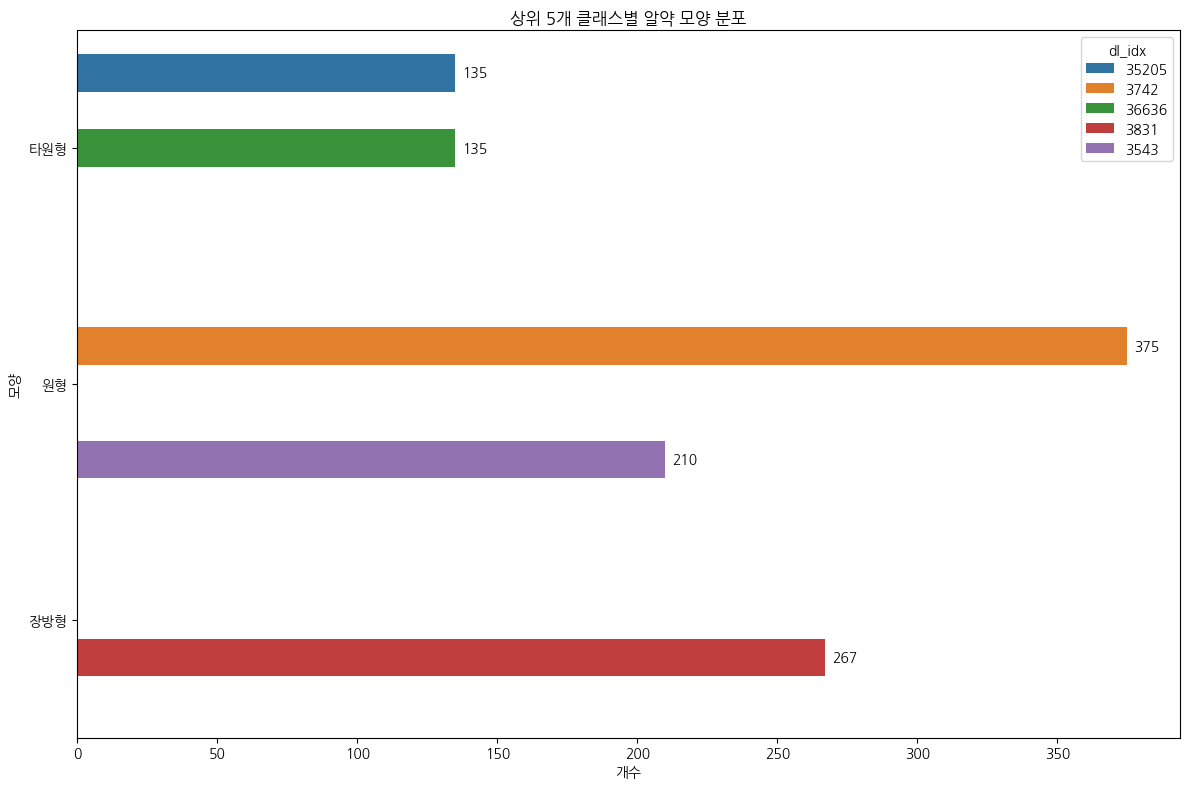


======== EDA 완료 ========



In [29]:
# --- 56개 클래스 이미지 및 어노테이션 파일 복사 ---
# 선별된 이미지와 어노테이션이 복사될 최종 폴더
output_base_dir_for_56_classes = os.path.join(DATA_ROOT, 'selected_TL_3_data') # 새로운 출력 베이스 폴더
output_images_dir = os.path.join(output_base_dir_for_56_classes, 'images')
output_annotations_dir = os.path.join(output_base_dir_for_56_classes, 'annotations')

os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_annotations_dir, exist_ok=True)

print(f"\n--- 56개 클래스 이미지 및 어노테이션 파일 '{output_base_dir_for_56_classes}'으로 복사 중 ---", flush=True)

copied_image_count = 0
copied_anno_count = 0

image_id_pattern = re.compile(r'^(K-\d{6}(?:-\d{6}){2,3})_.*\.png$')

try:
    # 필터링된 images_df_56_classes의 각 행을 반복하며 이미지 및 해당 JSON 복사
    for idx, row in images_df_56_classes.iterrows(): 
        image_filename = row['file_name']
        json_path_src = row['json_path'] # 원본 JSON 파일 경로 
        current_dl_idx = row['dl_idx']

        # 이미지 파일 경로 구성
        match = image_id_pattern.match(image_filename)
        if match:
            img_subfolder_name = match.group(1) # 예: 'K-003832-005391-022074' 또는 'K-003614-027653-031885-035206'
        else:
            print(f"경고: '{image_filename}'에서 이미지 서브폴더명을 추출할 수 없습니다. 건너뜀.", flush=True)
            continue
        
        # 최종 원본 이미지 경로: TRAIN_IMG_DIR / 이미지_고유ID_폴더 / 이미지파일명
        src_image_path = os.path.join(TRAIN_IMG_DIR, img_subfolder_name, image_filename)
        dest_image_path = os.path.join(output_images_dir, image_filename)
        
        # 어노테이션 파일 경로 구성
        # 원본 JSON 파일명을 그대로 사용
        json_filename = os.path.basename(json_path_src)
        dest_annotation_path = os.path.join(output_annotations_dir, json_filename)
        
        # 이미지 파일 복사
        if os.path.exists(src_image_path):
            if not os.path.exists(dest_image_path): # 이미 복사된 파일이면 다시 복사하지 않음
                shutil.copy(src_image_path, dest_image_path)
                copied_image_count += 1
        else:
            print(f"경고: 원본 이미지 '{src_image_path}'를 찾을 수 없습니다. (dl_idx: {current_dl_idx})", flush=True)
            
        # 어노테이션 파일 복사
        if not os.path.exists(dest_annotation_path): # 이미 복사된 파일이면 다시 복사하지 않음
            shutil.copy(json_path_src, dest_annotation_path)
            copied_anno_count += 1

except Exception as e:
    print(f"\n--- 복사 과정에서 예상치 못한 오류 발생: {e} ---", flush=True)
finally:
    print(f"\n--- 복사 요약 시작 ---", flush=True)
    print(f"DEBUG: Type of copied_image_count: {type(copied_image_count)}", flush=True)
    print(f"DEBUG: Value of copied_image_count: {copied_image_count}", flush=True)
    print(f"DEBUG: Type of copied_anno_count: {type(copied_anno_count)}", flush=True)
    print(f"DEBUG: Value of copied_anno_count: {copied_anno_count}", flush=True)

    print(f"최종 결과: 총 {copied_image_count}개의 56개 클래스 이미지가 '{output_images_dir}' 폴더로 복사되었습니다.", flush=True)
    print(f"            총 {copied_anno_count}개의 56개 클래스 어노테이션이 '{output_annotations_dir}' 폴더로 복사되었습니다.", flush=True)
    print(f"--- 복사 요약 끝 ---", flush=True)


# --- 심층 EDA 시작 ---
print("\n=====================================", flush=True)
print("======== Exploratory Data Analysis ========", flush=True)
print("=====================================\n", flush=True)

# 2.1. 데이터 개요
print("\n--- 2.1. 데이터 개요 (Images DataFrame - 56개 클래스) ---", flush=True)
print(images_df_56_classes.info(), flush=True)
print("\n--- Images DataFrame 기술 통계 (56개 클래스) ---", flush=True)
print(images_df_56_classes.describe(), flush=True)

print("\n--- 2.1. 데이터 개요 (Annotations DataFrame - 56개 클래스) ---", flush=True)
print(annotations_df_56_classes.info(), flush=True)
print("\n--- Annotations DataFrame 기술 통계 (56개 클래스) ---", flush=True)
print(annotations_df_56_classes.describe(), flush=True)

# 2.2. 결측치 확인
print("\n--- 2.2. 결측치 확인 (Images DataFrame - 56개 클래스) ---", flush=True)
print(images_df_56_classes.isnull().sum(), flush=True)
print("\n--- 2.2. 결측치 확인 (Annotations DataFrame - 56개 클래스) ---", flush=True)
print(annotations_df_56_classes.isnull().sum(), flush=True)

# 2.3. 클래스 분포 분석 (Class Distribution)
print("\n--- 2.3. 클래스 분포 분석 (Class Distribution) ---", flush=True)
plt.figure(figsize=(15, 6))
ax = sns.countplot(y='dl_idx', data=images_df_56_classes, order=images_df_56_classes['dl_idx'].value_counts().index)
plt.title('56개 클래스별 이미지 개수 분포')
plt.xlabel('이미지 개수')
plt.ylabel('클래스 ID (dl_idx)')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5) 
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2.3.2. dl_idx (56개 클래스)별 바운딩 박스 개수
plt.figure(figsize=(15, 6))
ax = sns.countplot(y='dl_idx', data=annotations_df_56_classes, order=annotations_df_56_classes['dl_idx'].value_counts().index)
plt.title('56개 클래스별 바운딩 박스(어노테이션) 개수 분포')
plt.xlabel('바운딩 박스 개수')
plt.ylabel('클래스 ID (dl_idx)')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2.4. 이미지 크기 분포
print("\n--- 2.4. 이미지 크기 분포 ---", flush=True)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(images_df_56_classes['width'], kde=True, bins=50)
plt.title('이미지 Width 분포')
plt.xlabel('Width (픽셀)')
plt.ylabel('빈도')

plt.subplot(1, 2, 2)
sns.histplot(images_df_56_classes['height'], kde=True, bins=50)
plt.title('이미지 Height 분포')
plt.xlabel('Height (픽셀)')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))

sns.scatterplot(x='width', y='height', data=images_df_56_classes, alpha=0.5)
plt.title('이미지 Width vs Height')
plt.xlabel('Width (픽셀)')
plt.ylabel('Height (픽셀)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 2.5. 바운딩 박스 크기 분포
print("\n--- 2.5. 바운딩 박스 크기 분포 ---", flush=True)

# 2.5.1. 바운딩 박스 너비/높이 분포
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(annotations_df_56_classes['bbox_width'], kde=True, bins=50)
plt.title('바운딩 박스 Width 분포')
plt.xlabel('Width (픽셀)')
plt.ylabel('빈도')

plt.subplot(1, 2, 2)
sns.histplot(annotations_df_56_classes['bbox_height'], kde=True, bins=50)
plt.title('바운딩 박스 Height 분포')
plt.xlabel('Height (픽셀)')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()

# 2.5.2. 바운딩 박스 면적 분포
plt.figure(figsize=(8, 6))

sns.histplot(annotations_df_56_classes['area'], kde=True, bins=50)
plt.title('바운딩 박스 면적 분포')
plt.xlabel('면적 (픽셀 제곱)')
plt.ylabel('빈도')
plt.tight_layout()
plt.show()

# 2.5.3. 이미지 대비 바운딩 박스 비율
merged_bbox_data = pd.merge(
    annotations_df_56_classes,
    images_df_56_classes[['image_id', 'width', 'height']],
    on='image_id',
    how='left'
)
merged_bbox_data['bbox_width_ratio'] = merged_bbox_data['bbox_width'] / merged_bbox_data['width']
merged_bbox_data['bbox_height_ratio'] = merged_bbox_data['bbox_height'] / merged_bbox_data['height']
merged_bbox_data['bbox_area_ratio'] = merged_bbox_data['area'] / (merged_bbox_data['width'] * merged_bbox_data['height'])

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(merged_bbox_data['bbox_width_ratio'], kde=True, bins=50)
plt.title('바운딩 박스 Width/Image Width 비율 분포')
plt.xlabel('비율')
plt.ylabel('빈도')

plt.subplot(1, 3, 2)
sns.histplot(merged_bbox_data['bbox_height_ratio'], kde=True, bins=50)
plt.title('바운딩 박스 Height/Image Height 비율 분포')
plt.xlabel('비율')
plt.ylabel('빈도')

plt.subplot(1, 3, 3)
sns.histplot(merged_bbox_data['bbox_area_ratio'], kde=True, bins=50)
plt.title('바운딩 박스 Area/Image Area 비율 분포')
plt.xlabel('비율')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()

# 2.6. 알약 속성 분포 (Images DataFrame)
print("\n--- 2.6. 알약 속성 분포 (Images DataFrame) ---", flush=True)

# 2.6.1. 약 모양 (drug_shape)
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='drug_shape', data=images_df_56_classes, order=images_df_56_classes['drug_shape'].value_counts().index)
plt.title('56개 클래스 알약 모양 분포')
plt.xlabel('개수')
plt.ylabel('모양')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5)
plt.tight_layout()
plt.show()

# 2.6.2. 주요 색상 (color_class1)
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='color_class1', data=images_df_56_classes, order=images_df_56_classes['color_class1'].value_counts().index)
plt.title('56개 클래스 알약 주요 색상 분포')
plt.xlabel('개수')
plt.ylabel('색상')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5)
plt.tight_layout()
plt.show()

# 2.6.3. 앞면 각인 (print_front) - 상위 20개
print("\n--- 앞면 각인 (print_front) 상위 20개 (56개 클래스) ---", flush=True)
print(images_df_56_classes['print_front'].value_counts().head(20), flush=True)

# 2.6.4. 뒷면 각인 (print_back) - 상위 20개
print("\n--- 뒷면 각인 (print_back) 상위 20개 (56개 클래스) ---", flush=True)
print(images_df_56_classes['print_back'].value_counts().head(20), flush=True)

# 2.7. 클래스별 특정 속성 비교 (예: 클래스별 알약 모양 분포)
print("\n--- 2.7. 클래스별 알약 모양 분포 (상위 N개 클래스) ---", flush=True)
num_top_classes_for_comparison = min(5, len(images_df_56_classes['dl_idx'].unique()))
if num_top_classes_for_comparison > 0:
    plt.figure(figsize=(12, 8))
    ax = sns.countplot(y='drug_shape', hue='dl_idx', data=images_df_56_classes[images_df_56_classes['dl_idx'].isin(top_dl_idx)])
    plt.title(f'상위 {num_top_classes_for_comparison}개 클래스별 알약 모양 분포')
    plt.xlabel('개수')
    plt.ylabel('모양')

    for container in ax.containers:
        ax.bar_label(container, fmt='%d', padding=5)
    plt.legend(title='dl_idx')
    plt.tight_layout()
    plt.show()
else:
    print("비교할 클래스가 충분하지 않아 클래스별 알약 모양 분포를 그릴 수 없습니다.", flush=True)

print("\n=====================================", flush=True)
print("======== EDA 완료 ========", flush=True)
print("=====================================\n", flush=True)

# 4. 데이터 시각화 (샘플 이미지와 어노테이션)


======== 샘플 이미지 및 어노테이션 시각화 ========


--- 무작위 샘플 이미지 5개 시각화 시작 ---


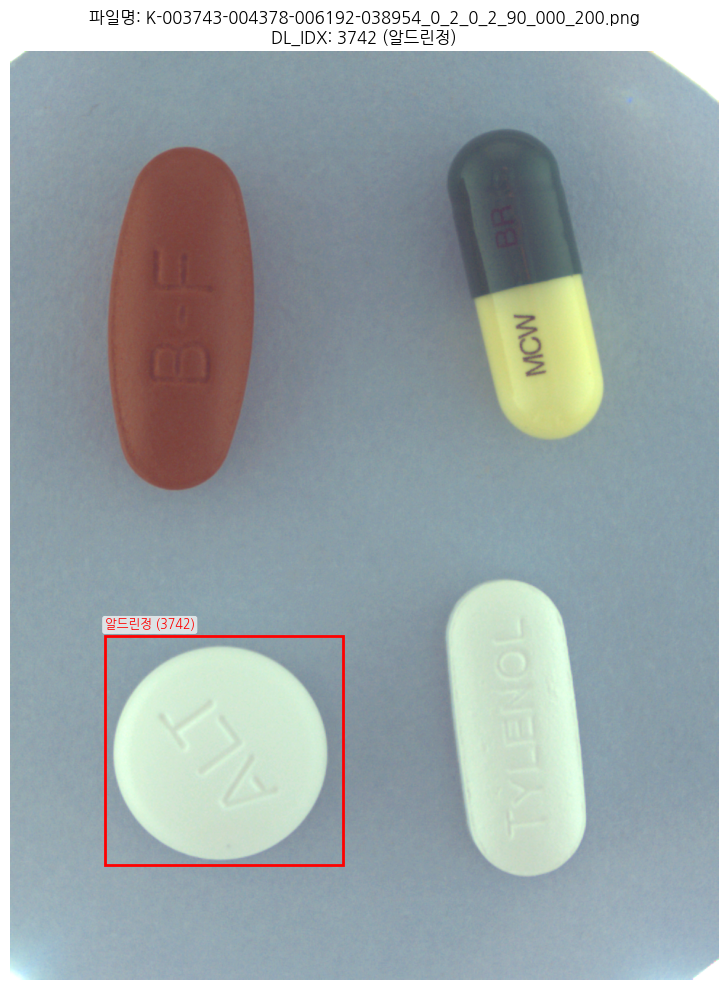

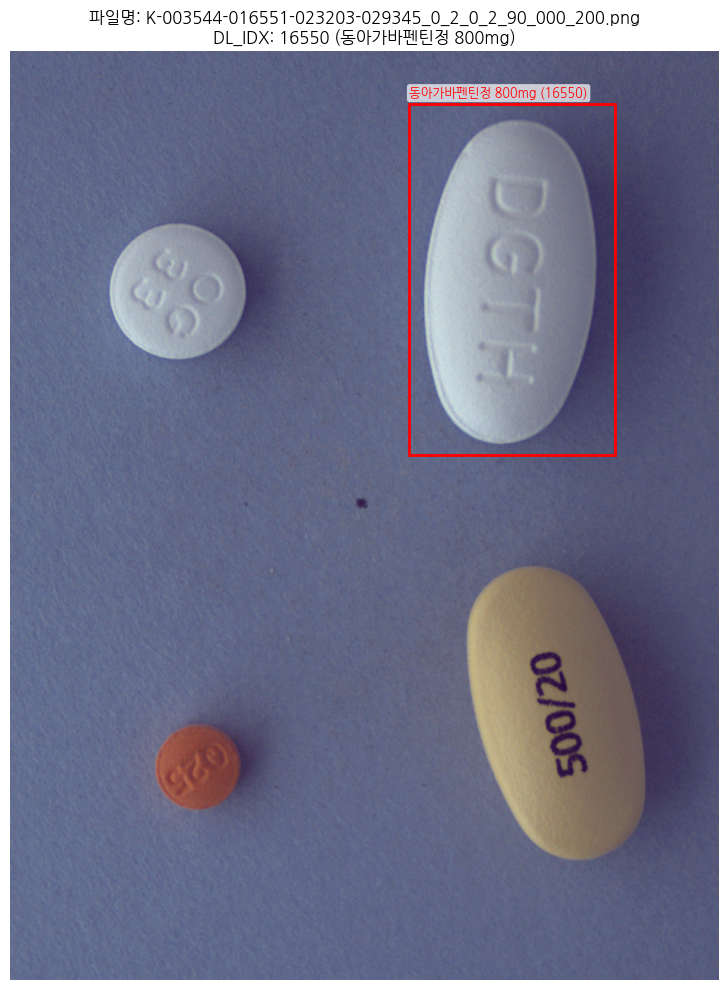

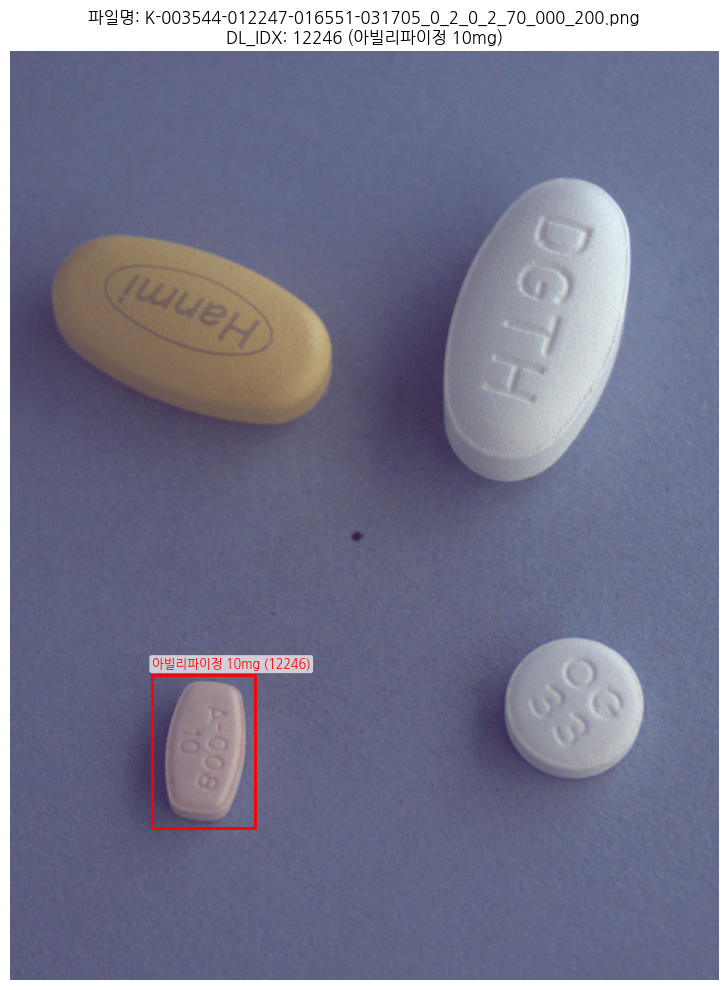

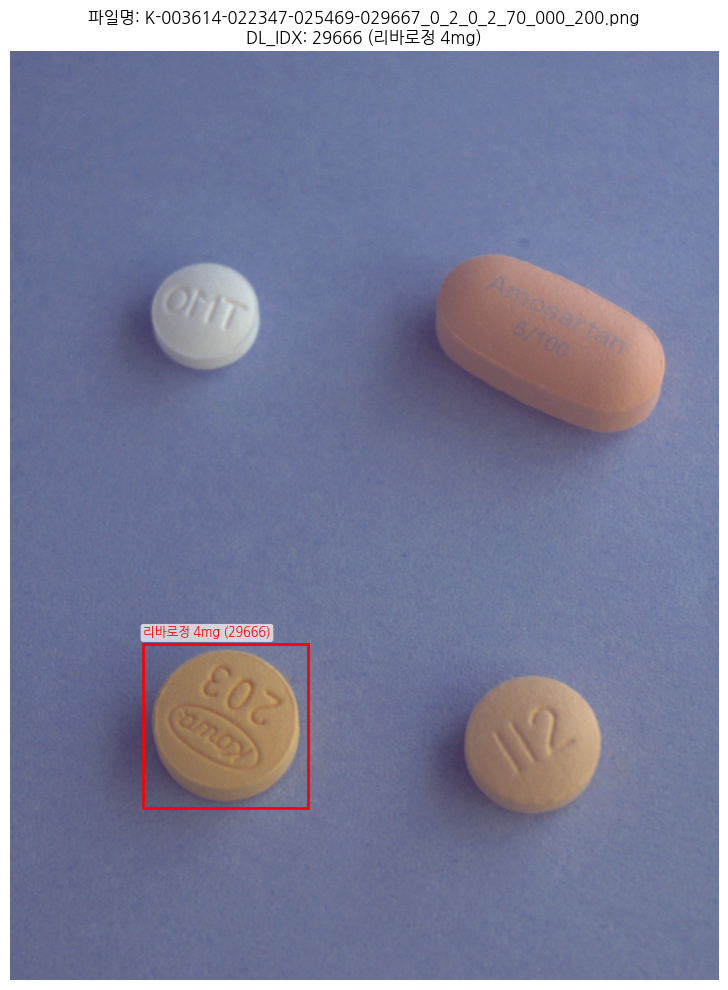

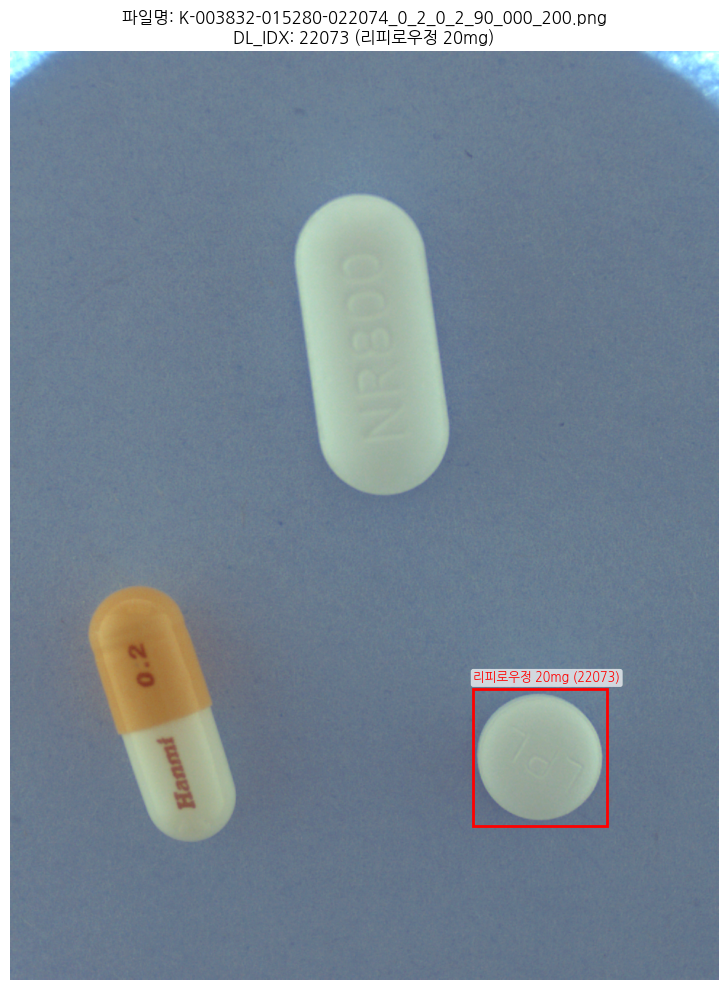


======== 샘플 시각화 완료 ========



In [31]:
import matplotlib.patches as patches # 바운딩 박스를 그리기 위해 임포트
import matplotlib.image as mpimg # 이미지 로드를 위해 명시적 임포트

print("\n=====================================", flush=True)
print("======== 샘플 이미지 및 어노테이션 시각화 ========", flush=True)
print("=====================================\n", flush=True)

# --- 9.1. 헬퍼 함수 정의: 이미지 로드 및 어노테이션 그리기 ---
def plot_image_with_annotations(image_row, annotations_df, base_image_dir, image_id_regex_pattern):
    """
    하나의 이미지에 해당하는 바운딩 박스와 정보를 시각화

    Args:
        image_row (pd.Series): images_df_56_classes DataFrame의 한 행 (이미지 메타데이터).
        annotations_df (pd.DataFrame): 전체 어노테이션 DataFrame.
        base_image_dir (str): 이미지 파일들이 저장된 루트 디렉토리.
        image_id_regex_pattern (re.Pattern): 이미지 파일명에서 서브폴더명을 추출하기 위한 정규표현식.
    """
    image_id = image_row['image_id']
    file_name = image_row['file_name']
    dl_idx = image_row['dl_idx'] # dl_idx (56개 클래스 ID)
    dl_name = image_row['dl_name'] # 알약 이름
    
    # 이미지 파일명에서 고유 ID 부분 추출
    match = image_id_pattern.match(file_name)
    if not match:
        print(f"경고: '{file_name}'에서 이미지 서브폴더명을 추출할 수 없어 시각화를 건너뜁니다.", flush=True)
        return

    img_subfolder_name = match.group(1) # 예: 'K-003832-005391-022074'
    
    # 최종 이미지 파일 경로 구성
    image_path = os.path.join(base_image_dir, img_subfolder_name, file_name)

    if not os.path.exists(image_path):
        print(f"경고: 이미지 파일 '{image_path}'를 찾을 수 없습니다. 시각화를 건너뜁니다.", flush=True)
        return

    # 이미지 로드
    img = mpimg.imread(image_path) # mpimg.imread 사용
    
    # 해당 이미지의 어노테이션 필터링
    img_annotations = annotations_df[annotations_df['image_id'] == image_id]
    
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)
    
    # 이미지 정보 표시 (전체 제목은 유지)
    ax.set_title(f"파일명: {file_name}\nDL_IDX: {dl_idx} ({dl_name})", fontsize=12) 
    ax.set_axis_off()

    # 바운딩 박스 그리기
    for _, anno_row in img_annotations.iterrows():
        xmin, ymin, bbox_width, bbox_height = anno_row['bbox']
        
        # 바운딩 박스 사각형 생성
        rect = patches.Rectangle(
            (xmin, ymin), bbox_width, bbox_height,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        
        # 알약 이름 (dl_name)과 dl_idx를 바운딩 박스 위에 표시
        label_text = f"{dl_name} ({dl_idx})"
        
        ax.text(xmin, ymin - 10, label_text,
                color='red', fontsize=9, backgroundcolor='white',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

    plt.tight_layout()
    plt.show()

image_id_pattern = re.compile(r'^(K-\d{6}(?:-\d{6}){2,3})_.*\.png$')

# --- 9.2. 샘플 이미지 선택 ---
# 56개 클래스 중 무작위로 5개의 이미지를 선택
num_sample_images_to_show = 5
if len(images_df_56_classes) > 0:
    sample_images = images_df_56_classes.sample(n=min(num_sample_images_to_show, len(images_df_56_classes)), random_state=42)
    print(f"\n--- 무작위 샘플 이미지 {len(sample_images)}개 시각화 시작 ---", flush=True)
    
    # --- 9.3. 각 샘플 이미지에 대해 시각화 함수 호출 ---
    for _, image_row in sample_images.iterrows():
        plot_image_with_annotations(image_row, annotations_df_56_classes, TRAIN_IMG_DIR, image_id_pattern)
else:
    print("\n경고: 시각화할 56개 클래스 이미지가 없어 샘플 시각화를 건너뜁니다.", flush=True)


print("\n=====================================", flush=True)
print("======== 샘플 시각화 완료 ========", flush=True)
print("=====================================\n", flush=True)